In [3]:
from collections import defaultdict
import itertools
import jax
import numpy as np

from benchmark import benchmark_chains, cumulative_avg, err, ess, get_num_latents
import blackjax
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
from blackjax.mcmc.mhmclmc import rescale
from blackjax.util import run_inference_algorithm
import jax.numpy as jnp 

from inference_models import models


In [29]:

from find_params import sampler_mhmclmc


results = defaultdict(float)
for model in ["Banana"]:
    # for step_size, L in itertools.product([16.866055/10], [16.866055]):
    for step_size, L in itertools.product(np.linspace(1,3, 10), np.linspace(12,16, 10)):
    # for sampler in ["mhmclmc"]:
        # result, bias = benchmark_chains(models[model], sampler_mhmclmc_with_tuning(step_size, L), n=1000000, batch=1)
        # result, bias = benchmark_chains(models[model], samplers[sampler], n=100000, batch=100, favg= jnp.array([100.0, 19.0]), fvar =jnp.array([20000.0, 4600.898]))
        result, bias = benchmark_chains(models[model], sampler_mhmclmc(step_size, L), n=100000, batch=10, favg= jnp.array([100.0, 19.0]), fvar =jnp.array([20000.0, 4600.898]))
        # result, bias = benchmark_chains(models[model], samplers["mhmclmc"], n=1000000, batch=10)
        results[(model, step_size, L)] = (result.item(), bias.item())



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9651924 , 0.9652112 , 0.9647845 , 0.9653226 , 0.96605444,
       0.96529216, 0.9656164 , 0.96525156, 0.96514326, 0.96481985],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 12.0
crossing 677 16248.0 0.006154604
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.0129607  -0.00634151]
Empirical std [9.992651  4.3314667]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.96417594, 0.9641552 , 0.96409464, 0.96482295, 0.96487194,
       0.96452   , 0.96449   , 0.963956  , 0.9639206 , 0.9642914 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 12.444444
crossing 700 17422.22 0.0057397964
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01401635 -0.01193087]
Empirical std [9.98173   4.2999716]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9634256 , 0.96306825, 0.9633397 , 0.96362245, 0.9636872 ,
       0.9630409 , 0.9626768 , 0.9635178 , 0.96353436, 0.9633689 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 12.888887
crossing 594 15311.998 0.0065308264
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.0114138 0.0125512]
Empirical std [10.020734   4.4016533]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.96237105, 0.96271014, 0.9625121 , 0.9620227 , 0.96268207,
       0.96237373, 0.96257263, 0.9621943 , 0.96253234, 0.96252936],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 13.333335
crossing 733 19546.67 0.0051159607
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01471375 -0.00794707]
Empirical std [9.991906 4.344593]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9612866 , 0.9618891 , 0.9614606 , 0.9613333 , 0.9615949 ,
       0.9615765 , 0.96107996, 0.96157193, 0.9615142 , 0.96124667],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 13.777778
crossing 471 12978.667 0.0077049513
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.0121207   0.00921832]
Empirical std [10.013611   4.3937626]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9601043 , 0.960631  , 0.9606995 , 0.9605707 , 0.96061856,
       0.96070325, 0.960992  , 0.9605406 , 0.961348  , 0.9603012 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 14.222223
crossing 346 9841.778 0.010160766
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01699519  0.00569797]
Empirical std [10.008981   4.3564878]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9597758 , 0.95954937, 0.96023256, 0.9600398 , 0.9602119 ,
       0.9599944 , 0.960147  , 0.96003497, 0.9597627 , 0.9595147 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 14.666667
crossing 372 10912.0 0.0091642225
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01392449 -0.0117892 ]
Empirical std [9.980625 4.329264]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9584175 , 0.9587797 , 0.95862347, 0.9588315 , 0.9582324 ,
       0.95864385, 0.958767  , 0.9590357 , 0.95847803, 0.9588959 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 15.111114
crossing 490 14808.892 0.0067526996
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01650402  0.0102084 ]
Empirical std [10.016472   4.3697176]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.95786864, 0.9580881 , 0.9575881 , 0.95780444, 0.9587089 ,
       0.9577674 , 0.9578792 , 0.9579491 , 0.95752496, 0.95805985],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 15.555556
crossing 300 9333.334 0.010714285
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.00535286 0.00193419]
Empirical std [10.003247  4.349521]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.95644104, 0.9571634 , 0.9569637 , 0.9571178 , 0.9569993 ,
       0.9569067 , 0.95766425, 0.9571802 , 0.9574879 , 0.95665723],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 16.0
crossing 614 19648.0 0.0050895764
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.01155614 0.00500088]
Empirical std [10.0081625  4.359589 ]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9369717 , 0.9371525 , 0.9366763 , 0.9368231 , 0.93733215,
       0.937084  , 0.93737143, 0.9367217 , 0.9371967 , 0.9375229 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 9.818183
crossing 646 12685.093 0.007883269
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.00949104 -0.02141223]
Empirical std [9.964773 4.300118]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.93471974, 0.9358079 , 0.934725  , 0.93469584, 0.93576145,
       0.93501085, 0.93508   , 0.9358833 , 0.93570584, 0.9357816 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 10.181817
crossing 367 7473.4536 0.013380694
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01995077 -0.01258984]
Empirical std [9.98156   4.3360085]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.93357223, 0.9336532 , 0.9332595 , 0.93419343, 0.93377745,
       0.9341591 , 0.93377966, 0.93333656, 0.9339611 , 0.9331945 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 10.545455
crossing 822 17336.729 0.0057681007
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.02621722  0.00100181]
Empirical std [10.0040045  4.372165 ]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9312437 , 0.931744  , 0.93215454, 0.93190163, 0.9326298 ,
       0.931614  , 0.93230265, 0.9319636 , 0.93160003, 0.9323557 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 10.90909
crossing 314 6850.9087 0.014596604
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.01361154 0.0031521 ]
Empirical std [10.00725    4.3724937]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.92981684, 0.93074065, 0.92984676, 0.93053764, 0.9309614 ,
       0.9308748 , 0.9309878 , 0.9301131 , 0.93079215, 0.9300195 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 11.272727
crossing 150 3381.818 0.029569892
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01397157  0.00579109]
Empirical std [10.0090685  4.3678575]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9287693 , 0.92910856, 0.9289096 , 0.92882013, 0.92852277,
       0.9288417 , 0.9292647 , 0.9279329 , 0.92904145, 0.9286697 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 11.636365
crossing 559 13009.456 0.0076867165
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.0009694  0.00641548]
Empirical std [10.012132   4.3638654]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.926643  , 0.9270634 , 0.9272304 , 0.92786366, 0.92811805,
       0.9267391 , 0.92721766, 0.92741543, 0.9284868 , 0.92731154],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 12.0
crossing 321 7704.0 0.01298027
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.00086573 -0.013167  ]
Empirical std [9.97827   4.3386707]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.9265804 , 0.92574906, 0.92551196, 0.92637944, 0.92631966,
       0.92686045, 0.926079  , 0.9258277 , 0.9262644 , 0.9256851 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 12.363635
crossing 784 19386.18 0.005158314
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01273706 -0.00558517]
Empirical std [9.989895 4.336134]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.92353016, 0.9241495 , 0.92340153, 0.92463297, 0.9241078 ,
       0.92459387, 0.923871  , 0.9240379 , 0.9243502 , 0.92394936],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 12.727273
crossing 716 18225.455 0.0054868315
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.01178789 0.00989401]
Empirical std [10.019052   4.3863974]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.92317665, 0.92296433, 0.9221584 , 0.9226611 , 0.9236476 ,
       0.9233869 , 0.9226492 , 0.92286825, 0.9229359 , 0.9223279 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 13.090911
crossing 279 7304.7285 0.013689763
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01482014  0.00672491]
Empirical std [10.011113  4.357786]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.89988524, 0.90123886, 0.9003296 , 0.9026977 , 0.902237  ,
       0.90160453, 0.9027249 , 0.90232956, 0.9026195 , 0.90130895],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.307693
crossing 441 7327.385 0.013647434
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.00328273 0.02183217]
Empirical std [10.036343   4.3972745]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.89886093, 0.9002278 , 0.89895755, 0.8996581 , 0.8998024 ,
       0.89894795, 0.8992163 , 0.8989014 , 0.899373  , 0.898779  ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.615386
crossing 2069 35650.47 0.0028050123
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01511668 -0.01331941]
Empirical std [9.978938 4.310168]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.89612013, 0.895401  , 0.89623404, 0.89735794, 0.8957249 ,
       0.8967255 , 0.89734787, 0.897851  , 0.8981482 , 0.8967957 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.923078
crossing 1979 35317.543 0.0028314542
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00591896  0.00102574]
Empirical std [10.003044   4.3294683]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8944192 , 0.8950239 , 0.894564  , 0.89358324, 0.8950377 ,
       0.89427704, 0.89471686, 0.89555395, 0.89597887, 0.8941851 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 9.230769
crossing 1991 36756.92 0.002720576
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.02808421 -0.01169008]
Empirical std [9.984858  4.2945085]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.89149094, 0.8910332 , 0.89070505, 0.89293784, 0.8924182 ,
       0.891669  , 0.89278805, 0.8936789 , 0.89314467, 0.8915591 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 9.538461
crossing 622 11865.845 0.00842755
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.03206424 0.01411648]
Empirical std [10.024515   4.4061255]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8900349 , 0.88920325, 0.88854426, 0.8902959 , 0.8903685 ,
       0.89031106, 0.8892531 , 0.88961905, 0.8906004 , 0.8891099 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 9.846154
crossing 308 6065.231 0.016487418
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00855854  0.02010409]
Empirical std [10.036977  4.407525]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.88678914, 0.8878668 , 0.8868287 , 0.8875883 , 0.88705075,
       0.88767534, 0.8890073 , 0.88805646, 0.88727796, 0.8876806 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 10.153846
crossing 522 10600.615 0.009433415
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.03642006 -0.00571866]
Empirical std [9.988657 4.336252]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.88436794, 0.88553107, 0.8849742 , 0.88632053, 0.88563997,
       0.8848379 , 0.88498795, 0.88446194, 0.8848751 , 0.8850174 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 10.461539
crossing 2795 58480.004 0.0017099862
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01418967  0.00510268]
Empirical std [10.008653   4.3824863]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.88213706, 0.8817542 , 0.88271576, 0.881585  , 0.88253   ,
       0.88356256, 0.8827603 , 0.8825367 , 0.8840103 , 0.88332546],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 10.769233
crossing 565 12169.233 0.008217445
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00889585  0.01363106]
Empirical std [10.020281  4.407789]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8788644 , 0.88055396, 0.8811806 , 0.87997776, 0.88016945,
       0.88047856, 0.88116646, 0.88096684, 0.8805572 , 0.8809471 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 11.076922
crossing 12048 266909.53 0.0003746588
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01569043  0.01417821]
Empirical std [10.02046    4.4079757]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.86050785, 0.8601381 , 0.8599407 , 0.8613981 , 0.8611813 ,
       0.8613856 , 0.85969657, 0.85998046, 0.861985  , 0.86081344],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.2000003
crossing 1556 22406.4 0.0044630105
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01790682  0.00307698]
Empirical std [10.006023   4.3632936]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.85705614, 0.85591614, 0.8564167 , 0.8559744 , 0.8567038 ,
       0.8574564 , 0.8583102 , 0.85740304, 0.8572333 , 0.8564076 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.4666667
crossing 866 12932.267 0.0077325967
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.02214726  0.03270051]
Empirical std [10.050103   4.4129095]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8521421 , 0.853158  , 0.8538908 , 0.8529198 , 0.8558962 ,
       0.85564363, 0.8545581 , 0.853966  , 0.8539353 , 0.8548335 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.733333
crossing 1820 28149.332 0.0035524822
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.00408993 0.00280783]
Empirical std [10.005063  4.377568]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8510177 , 0.8508656 , 0.8506693 , 0.8528021 , 0.8512202 ,
       0.85069406, 0.85214835, 0.85228854, 0.85215086, 0.8495654 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.0
crossing 1418 22688.0 0.0044076163
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.02968413 -0.00935984]
Empirical std [9.983728 4.329233]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.84862   , 0.84797597, 0.8477752 , 0.8494921 , 0.84867865,
       0.84865755, 0.84884644, 0.8480286 , 0.84847647, 0.8483279 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.266665
crossing 1041 17211.197 0.005810171
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.03549179 -0.02390365]
Empirical std [9.961375  4.3179064]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.842939  , 0.844085  , 0.8449743 , 0.8441909 , 0.84594214,
       0.8452823 , 0.8452855 , 0.8439046 , 0.84516895, 0.8443772 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.533334
crossing 616 10513.067 0.009511972
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.00299931 0.01806694]
Empirical std [10.027171  4.414724]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8397305 , 0.8413131 , 0.84365827, 0.8430356 , 0.84297544,
       0.84253305, 0.84226406, 0.84310114, 0.8432143 , 0.841884  ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.800001
crossing 1495 26312.004 0.0038005468
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.01939927 0.00894271]
Empirical std [10.011102   4.3640637]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.83728904, 0.8378304 , 0.839949  , 0.83881545, 0.8395981 ,
       0.83974046, 0.8407339 , 0.83982956, 0.83975625, 0.83921546],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 9.066667
crossing 1655 30010.666 0.0033321485
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00565857 -0.03092434]
Empirical std [9.944588  4.2679443]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.83655375, 0.8384267 , 0.8358752 , 0.8350068 , 0.83697903,
       0.83678573, 0.83706707, 0.8356979 , 0.8370417 , 0.83435434],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 9.333334
crossing 963 17976.002 0.0055629723
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.02535855 0.00449974]
Empirical std [10.0105295  4.418013 ]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8339684 , 0.83280444, 0.8336628 , 0.83283967, 0.8324225 ,
       0.83454067, 0.8328749 , 0.8333199 , 0.8332686 , 0.83254105],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 9.599999
crossing 849 16300.799 0.006134669
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01565659 -0.00505329]
Empirical std [9.9911175 4.3415174]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.81398016, 0.8164169 , 0.8149505 , 0.81657445, 0.8151811 ,
       0.81325793, 0.813322  , 0.81608415, 0.81590074, 0.81605834],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.3529406
crossing 1350 17152.94 0.0058299047
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.0656774  0.0229428]
Empirical std [10.038473  4.366736]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8105462 , 0.8132217 , 0.8081525 , 0.81278497, 0.81034833,
       0.8145712 , 0.8093044 , 0.8111179 , 0.81126475, 0.81104887],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.588235
crossing 1349 17775.059 0.0056258603
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.00477256 0.00491855]
Empirical std [10.006703  4.374064]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8080005 , 0.80522263, 0.8069839 , 0.8071959 , 0.806686  ,
       0.80826324, 0.8070364 , 0.80607265, 0.8084291 , 0.806832  ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.8235292
crossing 3035 41418.824 0.002414361
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01967935  0.01680499]
Empirical std [10.030013   4.4793897]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.8035491 , 0.80418795, 0.8032335 , 0.8043814 , 0.80355066,
       0.80446976, 0.8053606 , 0.8032592 , 0.80388415, 0.8033715 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.0588236
crossing 2043 28842.354 0.0034671235
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00535243 -0.00168439]
Empirical std [9.998062  4.3283114]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.799069  , 0.8004781 , 0.7973295 , 0.8017085 , 0.79866457,
       0.8012256 , 0.80036825, 0.79934484, 0.8001899 , 0.8000918 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.294118
crossing 666 9715.765 0.010292551
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.03349086 -0.00195087]
Empirical std [9.9983835 4.3636336]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7942836 , 0.79640216, 0.7955274 , 0.79824305, 0.7963707 ,
       0.79579324, 0.7965157 , 0.79710126, 0.7968309 , 0.79616195],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.5294123
crossing 1074 16173.178 0.0061830766
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.073662    0.01397604]
Empirical std [10.020811   4.4124765]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7917053 , 0.7915216 , 0.7925742 , 0.7919983 , 0.7917775 ,
       0.7936027 , 0.7931171 , 0.7933704 , 0.79101413, 0.7913574 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.7647066
crossing 1211 18806.12 0.0053174184
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.00662198 -0.00623967]
Empirical std [9.988755 4.336442]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7878617 , 0.7891481 , 0.78674746, 0.7900773 , 0.79042816,
       0.78814125, 0.787905  , 0.78539217, 0.7895542 , 0.78612036],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.0
crossing 1119 17904.0 0.005585344
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.00249916 0.03730753]
Empirical std [10.063902   4.4273386]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.785489  , 0.78541857, 0.7850807 , 0.7844306 , 0.7854193 ,
       0.784985  , 0.7838788 , 0.7864173 , 0.78605694, 0.787459  ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.235293
crossing 1099 18101.176 0.005524503
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.04534183 -0.00878367]
Empirical std [9.979549  4.3422985]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7829898 , 0.7823352 , 0.779656  , 0.7771528 , 0.7826339 ,
       0.78223693, 0.78140044, 0.78294146, 0.7823154 , 0.7796445 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 8.470589
crossing 3292 55770.355 0.0017930673
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00022855  0.00575807]
Empirical std [10.008259   4.4122977]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7697222 , 0.77312154, 0.7681853 , 0.77441764, 0.76801527,
       0.77130497, 0.76872873, 0.7693566 , 0.77064717, 0.76921475],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.6842113
crossing 2306 26215.582 0.0038145252
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.00339952 -0.01446828]
Empirical std [9.981195  4.3317986]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.76741445, 0.7632166 , 0.76478904, 0.7658841 , 0.76484466,
       0.7651639 , 0.7652569 , 0.7678049 , 0.76589733, 0.764819  ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.894737
crossing 3906 46049.684 0.0021715676
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.03587477 -0.0227229 ]
Empirical std [9.963014  4.3000946]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.75801235, 0.7592117 , 0.7605467 , 0.76195484, 0.76027477,
       0.7594579 , 0.7607829 , 0.76168054, 0.7570598 , 0.7591316 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.105263
crossing 627 7656.0 0.013061651
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01937121  0.03729986]
Empirical std [10.058049   4.4674134]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7550684 , 0.7578378 , 0.75635695, 0.7549932 , 0.75892687,
       0.7551796 , 0.75613105, 0.7579076 , 0.75691223, 0.7551052 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.315789
crossing 1889 23861.05 0.00419093
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00033499 -0.00405937]
Empirical std [9.994464  4.3546805]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7499667 , 0.75407845, 0.75160855, 0.752041  , 0.7513233 ,
       0.7506973 , 0.7507978 , 0.7506955 , 0.75295544, 0.7524452 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.5263147
crossing 1201 15676.208 0.0063790935
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.06733055 -0.01688223]
Empirical std [9.9722805 4.321796 ]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7455628 , 0.7475306 , 0.74445313, 0.7465562 , 0.7482305 ,
       0.7476044 , 0.74304605, 0.7483874 , 0.74779123, 0.7459952 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.7368426
crossing 1813 24427.791 0.004093698
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.01968934 0.02565777]
Empirical std [10.038982   4.5043178]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.740994  , 0.7410229 , 0.7415403 , 0.7437407 , 0.7427188 ,
       0.74538845, 0.7432101 , 0.7425331 , 0.7433956 , 0.7415997 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.9473686
crossing 945 13130.526 0.007615841
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.0071082  0.00811816]
Empirical std [10.008837  4.346506]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7368262 , 0.7386748 , 0.73766136, 0.7404266 , 0.73934746,
       0.73644894, 0.7384716 , 0.73778296, 0.7384095 , 0.73856544],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.157895
crossing 615 8804.211 0.0113582015
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.04751421 -0.01030007]
Empirical std [9.981391  4.3210907]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.73482215, 0.7328331 , 0.73481536, 0.73352957, 0.7358372 ,
       0.73441195, 0.73265344, 0.73050284, 0.7362975 , 0.73496926],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.368421
crossing 2273 33496.844 0.002985356
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.02174432 -0.01987443]
Empirical std [9.970094  4.3290825]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7290172 , 0.72755355, 0.7303394 , 0.73146224, 0.7307653 ,
       0.73030007, 0.72906   , 0.72905517, 0.72973335, 0.7274612 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 7.5789485
crossing 2229 33786.953 0.0029597224
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.03145332 -0.00289545]
Empirical std [9.993444 4.313618]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.723644  , 0.7259539 , 0.7266181 , 0.72424555, 0.72897786,
       0.7235217 , 0.72731054, 0.72504646, 0.72830904, 0.7249137 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.142857
crossing 1156 11890.285 0.0084102275
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.0292136 -0.0542284]
Empirical std [9.914755 4.188536]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.71611905, 0.7190804 , 0.71927404, 0.71876234, 0.7206253 ,
       0.72092426, 0.7203348 , 0.72013044, 0.7212682 , 0.7168935 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.333333
crossing 1994 21269.332 0.004701605
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.05791263  0.01640038]
Empirical std [10.029249   4.3716207]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7130825 , 0.71021116, 0.712912  , 0.7156638 , 0.7115575 ,
       0.71150404, 0.7114781 , 0.71269536, 0.7153856 , 0.70943093],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.52381
crossing 10653 117690.3 0.0008496877
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.04607971  0.07141824]
Empirical std [10.120016   4.5064845]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7116345 , 0.70941216, 0.7096857 , 0.70765996, 0.71159106,
       0.7085658 , 0.7111025 , 0.70859313, 0.7118598 , 0.70788443],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.7142863
crossing 2173 24834.29 0.0040266905
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01539718  0.00854815]
Empirical std [10.012442   4.3514247]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7078869 , 0.70587504, 0.7072349 , 0.7028488 , 0.7021986 ,
       0.70363235, 0.7043253 , 0.7074615 , 0.70864606, 0.7041595 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.904762
crossing 1959 23134.857 0.004322482
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.06144277 -0.03274202]
Empirical std [9.948394  4.2466955]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.7003339 , 0.69807965, 0.70029974, 0.6998237 , 0.699621  ,
       0.7007824 , 0.7017492 , 0.7027681 , 0.7037768 , 0.70206577],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.095238
crossing 1648 20089.904 0.0049776244
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.03857136 -0.03097899]
Empirical std [9.947358 4.271776]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.69446373, 0.690897  , 0.6979569 , 0.691015  , 0.693601  ,
       0.69584864, 0.69576764, 0.69559824, 0.69412804, 0.6941843 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.2857137
crossing 4700 59085.707 0.0016924567
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00407137  0.03203035]
Empirical std [10.055225  4.458548]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.68992406, 0.6914182 , 0.68896216, 0.691821  , 0.6910299 ,
       0.69087017, 0.69207984, 0.6901524 , 0.69178164, 0.69224256],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.4761896
crossing 2752 35644.95 0.0028054465
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01375616 -0.03308151]
Empirical std [9.946566 4.260831]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.68639046, 0.6884377 , 0.6859258 , 0.68803805, 0.6860281 ,
       0.68702334, 0.6894074 , 0.6880004 , 0.6886502 , 0.6839226 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.6666675
crossing 1245 16600.002 0.0060240957
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01385721 -0.03892163]
Empirical std [9.935042  4.2259765]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6774915 , 0.6807245 , 0.68010193, 0.68303406, 0.68511856,
       0.6808926 , 0.68375427, 0.68047   , 0.6833685 , 0.67998743],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.857143
crossing 8206 112539.43 0.00088857743
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.0447025  -0.01935516]
Empirical std [9.966884 4.291763]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.67157024, 0.66084707, 0.6778607 , 0.67736024, 0.67881453,
       0.6760478 , 0.67623794, 0.68165594, 0.68127733, 0.6747587 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.695652
crossing 100000 939130.4 0.000106481486
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.10567892  0.09897194]
Empirical std [10.165054  4.780831]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6729065 , 0.6707406 , 0.6772632 , 0.6741583 , 0.6721934 ,
       0.6726837 , 0.67169946, 0.67360735, 0.6770056 , 0.6705199 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.8695645
crossing 1086 10576.694 0.0094547495
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.05136153 -0.09668177]
Empirical std [9.836953  4.1058493]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6618777 , 0.66376966, 0.66704726, 0.6644169 , 0.6667935 ,
       0.6672605 , 0.66849387, 0.6658286 , 0.6644369 , 0.6644185 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.043479
crossing 891 8987.4795 0.01112659
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.06284948 -0.02038702]
Empirical std [9.968181 4.242194]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.66056544, 0.6600132 , 0.66279584, 0.6602234 , 0.6603539 ,
       0.6588682 , 0.6622116 , 0.66303176, 0.66234016, 0.661906  ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.2173915
crossing 1089 11363.479 0.008800122
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.06707213 -0.02118336]
Empirical std [9.967164 4.232016]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6556161 , 0.6548806 , 0.6576732 , 0.6560788 , 0.6520493 ,
       0.66240317, 0.6579508 , 0.6563408 , 0.6564643 , 0.65314484],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.3913045
crossing 20654 222704.0 0.0004490265
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.07388294 -0.04064262]
Empirical std [9.929697 4.224737]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.64942586, 0.6528666 , 0.64955676, 0.65066314, 0.6491517 ,
       0.65065926, 0.65194577, 0.65236294, 0.65102047, 0.65192366],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.565217
crossing 3833 42662.953 0.002343954
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01835077 -0.02956342]
Empirical std [9.949474  4.2199297]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6450373 , 0.6454814 , 0.647556  , 0.650748  , 0.6456607 ,
       0.6474769 , 0.64672136, 0.6416682 , 0.6444674 , 0.64602345],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.7391315
crossing 28681 329208.06 0.00030375927
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00122282 -0.0058902 ]
Empirical std [9.988053 4.38585 ]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6402066 , 0.63896513, 0.6418829 , 0.6443783 , 0.64081943,
       0.64056593, 0.64360857, 0.64041406, 0.64248085, 0.6431302 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.9130435
crossing 3935 46535.652 0.00214889
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.02331709 -0.00321471]
Empirical std [9.996792  4.3275104]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6369026 , 0.63341755, 0.6392004 , 0.6377005 , 0.62979656,
       0.6371164 , 0.6368131 , 0.6380884 , 0.63639706, 0.6362036 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.0869565
crossing 2991 36412.17 0.0027463343
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.06167819 0.02607717]
Empirical std [10.045574   4.4694543]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.63190156, 0.631565  , 0.6337927 , 0.6334639 , 0.6334031 ,
       0.63495284, 0.6320472 , 0.633977  , 0.63492686, 0.63517785],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 6.260869
crossing 836 10468.173 0.009552766
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01202032 -0.04363533]
Empirical std [9.926652  4.2216396]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6275332 , 0.6214905 , 0.62876457, 0.62384456, 0.62952316,
       0.62357837, 0.62534195, 0.62401575, 0.6261619 , 0.6245616 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.32
crossing 6725 58104.004 0.0017210518
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00817238 -0.03143549]
Empirical std [9.945132  4.2128034]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.61483544, 0.6193181 , 0.6212323 , 0.6178391 , 0.62068355,
       0.6179107 , 0.6165318 , 0.6205341 , 0.62257296, 0.61837196],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.48
crossing 5532 49566.72 0.0020174826
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.00260855 -0.03176769]
Empirical std [9.948512  4.1709905]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.60859454, 0.613441  , 0.6171566 , 0.6147599 , 0.6173121 ,
       0.4907003 , 0.61369044, 0.60893434, 0.6156411 , 0.61436456],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.64
crossing 100000 928000.0 0.00010775862
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.9635593 1.0493441]
Empirical std [11.575922  8.368223]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6058897 , 0.6094806 , 0.607857  , 0.6020645 , 0.609639  ,
       0.60787356, 0.6129995 , 0.6107892 , 0.6124509 , 0.6039008 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.7999997
crossing 52123 500380.78 0.0001998478
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.0903837  -0.02535801]
Empirical std [9.960564  4.3094964]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6013298 , 0.5990097 , 0.60294294, 0.6031567 , 0.6057987 ,
       0.6015063 , 0.60383415, 0.60328734, 0.59948224, 0.603558  ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.9599996
crossing 2834 28113.277 0.0035570383
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01586905 -0.03934995]
Empirical std [9.937707  4.2216916]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.59630114, 0.6000359 , 0.5887791 , 0.5982424 , 0.6007266 ,
       0.5972452 , 0.59876895, 0.59556013, 0.59901345, 0.5946142 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.1199994
crossing 19758 202321.89 0.0004942619
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.02728343 -0.01663684]
Empirical std [9.977065 4.300457]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5879988 , 0.5922192 , 0.5887255 , 0.5923076 , 0.5933164 ,
       0.59125227, 0.59168094, 0.59388626, 0.59510326, 0.59630924],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.28
crossing 2905 30676.8 0.0032597922
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.06950891 -0.03640521]
Empirical std [9.942647  4.1946063]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5885988 , 0.58362436, 0.58581954, 0.58695626, 0.58610445,
       0.58518726, 0.5891154 , 0.5907048 , 0.5894184 , 0.58342326],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.4399996
crossing 15378 167312.62 0.00059768354
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.04044538 -0.00208762]
Empirical std [10.00451    4.3062944]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5803636 , 0.58125126, 0.5795786 , 0.58165437, 0.58514094,
       0.5865743 , 0.5814264 , 0.58370733, 0.58395356, 0.57789683],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.5999994
crossing 980 10975.999 0.009110788
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01077164 -0.05072103]
Empirical std [9.918196  4.1925316]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.57580334, 0.5784493 , 0.5725828 , 0.5785479 , 0.57605433,
       0.5800372 , 0.57347655, 0.57378364, 0.5826353 , 0.57728404],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.7600007
crossing 39708 457436.22 0.00021860971
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.12834579 0.0073448 ]
Empirical std [10.009307   4.4032335]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.55770904, 0.5533732 , 0.5710421 , 0.56764567, 0.5718826 ,
       0.5689023 , 0.57343435, 0.5608446 , 0.5694428 , 0.56914175],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.0
crossing 85807 686456.0 0.00014567576
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.02984066  0.08237733]
Empirical std [10.138078   4.5549793]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5677256 , 0.5617236 , 0.5591831 , 0.56610245, 0.5612238 ,
       0.566371  , 0.5698902 , 0.5585933 , 0.56486875, 0.56276613],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.148148
crossing 33433 277370.06 0.00036052917
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01721653 -0.03586189]
Empirical std [9.938123  4.2594433]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.55833596, 0.55513453, 0.5542134 , 0.5396814 , 0.5588288 ,
       0.5557699 , 0.55938023, 0.543912  , 0.5599656 , 0.55626273],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.2962956
crossing 100000 859259.1 0.00011637933
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.00745137  0.19396587]
Empirical std [10.319403  5.035971]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.55301017, 0.55084664, 0.55053574, 0.5542446 , 0.5554883 ,
       0.5496992 , 0.55269676, 0.55078876, 0.5565231 , 0.5522058 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.444444
crossing 2765 24577.775 0.0040687164
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.02931079 -0.1293876 ]
Empirical std [9.785336  3.9638476]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.54165906, 0.54179543, 0.50320864, 0.545882  , 0.543479  ,
       0.54204875, 0.54995453, 0.5510206 , 0.5463201 , 0.5469477 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.592593
crossing 100000 918518.6 0.000108870954
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.28607258  0.25462505]
Empirical std [10.409693  5.332435]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5411954 , 0.5320401 , 0.5392001 , 0.53327763, 0.5338553 ,
       0.54046357, 0.5400662 , 0.5350461 , 0.5453566 , 0.5414627 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.7407413
crossing 25532 242081.22 0.0004130845
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.03527101  0.01051597]
Empirical std [10.017129  4.323555]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5292818 , 0.5341488 , 0.53506064, 0.5347334 , 0.5358977 ,
       0.5363567 , 0.5337754 , 0.5314687 , 0.5403756 , 0.53295517],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 4.888889
crossing 9048 88469.336 0.0011303351
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.12239919 -0.04493715]
Empirical std [9.924612  4.1553946]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5284933 , 0.5294922 , 0.52963644, 0.5342334 , 0.5253713 ,
       0.52477884, 0.5310894 , 0.5203409 , 0.5273685 , 0.5280372 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.037037
crossing 62153 626133.94 0.00015971024
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [-0.01115654 -0.00520915]
Empirical std [9.993528  4.3340983]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5231479 , 0.5242424 , 0.5232577 , 0.51536715, 0.52750516,
       0.52482176, 0.52291113, 0.5277123 , 0.52657175, 0.52225703],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.185185
crossing 12859 133352.6 0.0007498917
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.01438099 -0.05307861]
Empirical std [9.912247 4.207598]



Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.5135045 , 0.51739734, 0.50973463, 0.51466435, 0.51825196,
       0.5207496 , 0.51963484, 0.51885265, 0.5190066 , 0.5206221 ],      dtype=float32)
  batch_dim = 0 acceptance probability








AVG NUM STEPS PER TRAJ 5.333333
crossing 2702 28821.332 0.0034696523
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [0.10287794 0.00200346]
Empirical std [10.006878   4.2739544]


100
(100,)


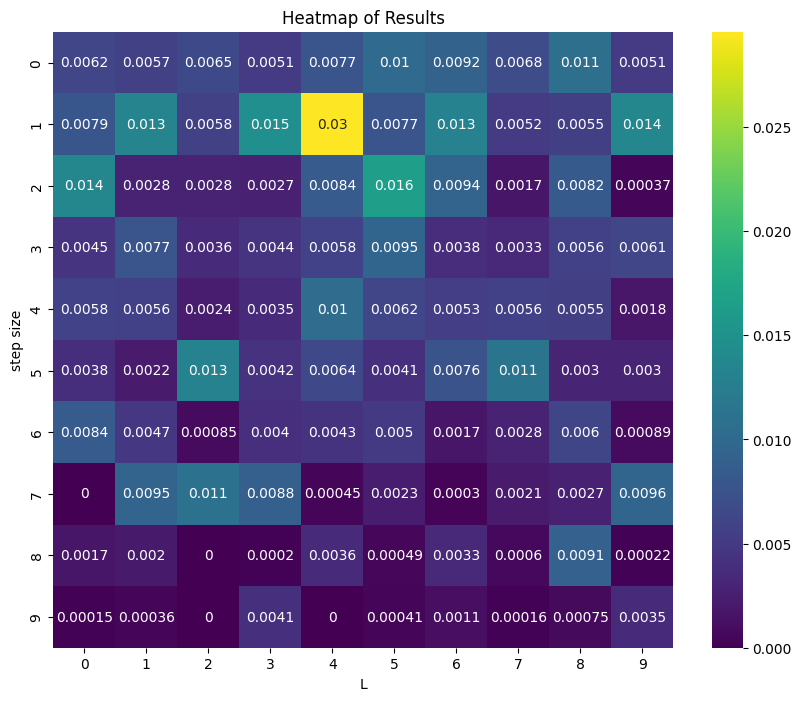

In [30]:
import seaborn as sns

import matplotlib.pyplot as plt

# Extract x and y values from the keys of the results dictionary
x_values = [key[0] for key in results.keys()]
y_values = [key[1] for key in results.keys()]

print(len(x_values))
# raise Exception

# Extract heat values from the dictionary
heat_values = list(x[0] for x in results.values())

print(np.array(heat_values).shape)
# Reshape the heat values into a 2D array
# heat_array = np.array(heat_values).reshape((len(x_values), len(y_values)))
heat_array = np.array(heat_values).reshape((10,10))

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heat_array, annot=True, cmap='viridis')
plt.xlabel('L')
plt.ylabel('step size')
plt.title('Heatmap of Results')
plt.show()


In [51]:

# results[('Banana', np.linspace(1,3,10)[1], np.linspace(12,16,10)[4])]
# results_1 = {results[key]: key for key in results.keys() if type(results[key]) is tuple}
# max(results_1, key=lambda x: results_1[x][0])
max([(results[r][0], r) for r in results if type(results[r]) is tuple])


(0.029569892212748528, ('Banana', 1.2222222222222223, 13.777777777777779))